# diagnoses_icd

먼저 diagnoses_icd csv파일에서 icd_code를 통해서 AKI 여부를 확인한다.
만약 AKI에 걸린 환자라면 target value에 1 그렇지 않으면 0이라는 값을 준다.

In [3]:
import pandas as pd

In [4]:
diagnoses = pd.read_csv('/data/share/AKI/3.0/hosp/diagnoses_icd.csv.gz', compression = 'gzip')

In [5]:
diagnoses.columns

Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version'], dtype='object')

In [6]:
print(diagnoses.head(10))
print('-----------------')
print(diagnoses.shape)

   subject_id   hadm_id  seq_num icd_code  icd_version
0    10000032  22595853        1     5723            9
1    10000032  22595853        2    78959            9
2    10000032  22595853        3     5715            9
3    10000032  22595853        4    07070            9
4    10000032  22595853        5      496            9
5    10000032  22595853        6    29680            9
6    10000032  22595853        7    30981            9
7    10000032  22595853        8    V1582            9
8    10000032  22841357        1    07071            9
9    10000032  22841357        2    78959            9
-----------------
(6364520, 5)


In [7]:
target_value = ['5845', '5846', '5847', '5848', '5849', '66930', '66932', '66934', 'N17', 'N170', 'N171', 'N172', 'N178', 'N179', 'Q904']

In [8]:
diagnoses = diagnoses.drop(['seq_num', 'icd_version'], axis = 1)

In [9]:
diagnoses['target'] = diagnoses['icd_code'].apply(lambda x : 1 if x in target_value else 0)
diagnoses['target'].value_counts() 
# AKI에 걸리지 않은 사람이 99% 이고 AKI에 걸린 사람이 1% 임을 확인할 수 있다.

'\nwithout AKI 0.99\nwith AKI 0.01\n'

In [39]:
aki_list = diagnoses[diagnoses['target'] == 1]['hadm_id'].unique()
not_aki_list = diagnoses[diagnoses['target'] == 0]['hadm_id'].unique()

#aki_list에 aki에 걸린 환자의 hadm_id 값을 저장한다. 비슷한 방식으로 aki에 걸리지 않은 환자의 hadm_id 값을 not_aki_list에 저장한다.

위의 과정까지가 aki_list를 확인하는 것인데, 아래는 초은이가 준 aki_hadm csv에서 불러와서 하는 방법! 아래부터 참고해도 충분하다 

# Ingredients

In [10]:
import gc
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

icu_path = '/data/share/AKI/3.0/icu/'
label_data = pd.read_csv('/home/stateun/aki_hadm.csv')

label_subject = label_data['subject_id']
label_hadm = label_data['hadm_id']
label_aki = label_data['aki']

aki_list = label_data[ label_data['aki'] > 0 ]['hadm_id']
not_aki_list = label_data[label_data['aki'] == 0]['hadm_id']

In [11]:
ingredients = pd.read_csv('/data/share/AKI/3.0/icu/ingredientevents.csv.gz', compression = 'gzip')

In [12]:
ingredients.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'caregiver_id', 'starttime',
       'endtime', 'storetime', 'itemid', 'amount', 'amountuom', 'rate',
       'rateuom', 'orderid', 'linkorderid', 'statusdescription',
       'originalamount', 'originalrate'],
      dtype='object')

In [13]:
# 우리가 예측하고자하는 AKI 판별 여부에 유의미하지 않은 column들은 모두 제거한다. 이 과정을 한 번 더 뒤에서 하게 되는데 여기서 미리하는 이유는 column을 삭제하고 코딩 결과 속도를 빨리내기 위해서이다.
ingredients = ingredients.drop(['stay_id', 'caregiver_id', 'storetime', 'amountuom', 'rate', 'rateuom',
                          'statusdescription', 'originalamount', 'originalrate'], axis=1)

In [14]:
# ICU 디렉토리의 파일에는 hosp와 다르게 정상수치인지 아닌지에 대한 정보가 없기 때문에 이상치 여부를 확인하고 이를 직접 제거한다.

def compute_stats(group):
    min_val = group.min()
    max_val = group.max()
    mean = group.mean()
    q1 = group.quantile(0.25)
    q3 = group.quantile(0.75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    return pd.Series({'min': min_val, 'max': max_val,'mean' : mean, 'Q1-1.5*IQR' : lower_fence ,'Q3+1.5*IQR': upper_fence})

stats = ingredients.groupby('itemid')['amount'].apply(compute_stats).unstack().reset_index()
stats.head(20)

,itemid,min,max,mean,Q1-1.5*IQR,Q3+1.5*IQR
0,220363,3.600000e-07,4.500000e+00,0.051046,-0.049909,0.131182
1,220364,0.000000e+00,1.200000e+05,16273.805032,-6250.000180,43750.001260
2,220395,0.000000e+00,1.200000e+05,16273.805032,-6250.000180,43750.001260
3,220412,0.000000e+00,4.800000e+02,65.095218,-25.000000,175.000000
4,220413,0.000000e+00,2.011200e+03,272.748968,-104.750001,733.250009
5,220454,0.000000e+00,8.286736e+04,26.001030,-36.074228,79.917000
6,220490,-1.510000e+01,1.000400e+06,159.773997,-171.609487,348.299020
7,226060,-1.164163e+01,3.322462e+05,79.136992,-53.310588,99.986355
8,226221,0.000000e+00,1.500000e+04,360.916162,-470.913199,1082.547883
9,226366,0.000000e+00,3.600000e+04,1524.250705,-2325.000000,5075.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc029907910>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc029907e50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc029907670>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc030f053d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc030f05670>],
 'means': []}

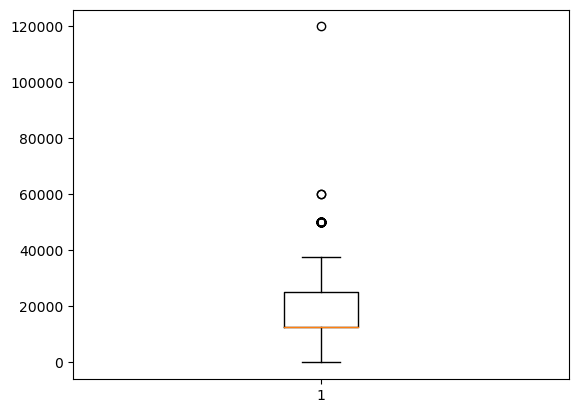

In [16]:
# boxplot으로 이상치 여부를 확인한다.

plt.boxplot(ingredients[(ingredients['itemid'] == 220364)]['amount'])

In [17]:
# 몇퍼센트가 이상치 인지 정확하게 보기 위해서 qunatile을 보는데 대부분의 파일에서 99%이상 값이 정상이지만, 보통 Q1 - 1.5IQR, Q3 + 1.5IQR 이면 이상치로 판단하기 때문에 이 기준을 가지고 값들을 제거할 것이다.
ingredients[ingredients['itemid'] == 220364]['amount'].quantile(0.999)

50000.00143982464

In [18]:
"""
Remove the Outlier
"""

ingredients = pd.read_csv(icu_path + 'ingredientevents.csv.gz', compression='gzip', chunksize=10**6)

for i, chunk in enumerate(tqdm(ingredients, desc='Processing chunks')):

    chunk = chunk.merge(stats[['itemid', 'Q1-1.5*IQR', 'Q3+1.5*IQR']], on='itemid', how='left')
    chunk.head(5)

    chunk.dropna(subset=['Q1-1.5*IQR', 'Q3+1.5*IQR'], inplace=True)

    mask = (chunk['amount'] >= chunk['Q1-1.5*IQR']) & (chunk['amount'] <= chunk['Q3+1.5*IQR'])
    chunk = chunk[mask]

    chunk.drop(['Q1-1.5*IQR', 'Q3+1.5*IQR'], axis=1, inplace=True)

    chunk.to_csv(f'preprocessing_ingredient_{i}.csv', index=False)
    
    print(f'{i}-th preprocessing complete.')

    del chunk
    gc.collect()

Processing chunks: 1it [00:09,  9.43s/it]

0-th preprocessing complete.


Processing chunks: 2it [00:18,  9.26s/it]

1-th preprocessing complete.


Processing chunks: 3it [00:27,  9.22s/it]

2-th preprocessing complete.


Processing chunks: 4it [00:36,  9.18s/it]

3-th preprocessing complete.


Processing chunks: 5it [00:45,  9.15s/it]

4-th preprocessing complete.


Processing chunks: 6it [00:55,  9.11s/it]

5-th preprocessing complete.


Processing chunks: 7it [01:03,  9.04s/it]

6-th preprocessing complete.


Processing chunks: 8it [01:12,  8.99s/it]

7-th preprocessing complete.


Processing chunks: 9it [01:21,  8.97s/it]

8-th preprocessing complete.


Processing chunks: 10it [01:30,  8.90s/it]

9-th preprocessing complete.


Processing chunks: 11it [01:39,  8.88s/it]

10-th preprocessing complete.


Processing chunks: 12it [01:47,  8.83s/it]

11-th preprocessing complete.


Processing chunks: 13it [01:56,  8.83s/it]

12-th preprocessing complete.


Processing chunks: 14it [02:05,  8.82s/it]

13-th preprocessing complete.


Processing chunks: 15it [02:07,  8.53s/it]

14-th preprocessing complete.


In [19]:
stats.head(5)

,itemid,min,max,mean,Q1-1.5*IQR,Q3+1.5*IQR
0,220363,3.600000e-07,4.500000,0.051046,-0.049909,0.131182
1,220364,0.000000e+00,120000.001930,16273.805032,-6250.000180,43750.001260
2,220395,0.000000e+00,120000.001930,16273.805032,-6250.000180,43750.001260
3,220412,0.000000e+00,480.000000,65.095218,-25.000000,175.000000
4,220413,0.000000e+00,2011.200072,272.748968,-104.750001,733.250009


In [20]:
file_path = '/home/stateun/'
output_file = '/home/stateun/ingredients.csv'
# chunk로 파일들을 불러와서 outlier를 제거하고, 제거한 파일들을 다시 하나로 붙이는 과정이다.

for i in range(0,14):
    file_name = f'preprocessing_ingredient_{i}.csv'
    full_path = os.path.join(file_path, file_name)
    
    chunk = pd.read_csv(full_path)
    if i == 1:
        chunk.to_csv(output_file, mode='w', index=False)
    else:
        chunk.to_csv(output_file, mode='a', index=False, header=False)
        
    print(f'{i+1}/{14}번째 파일 처리 완료: {file_name}')
    
    try :
        os.remove(full_path)
    except Exception as e:
        print(f'{file_name} 파일 삭제 중 오류 발생 : {e}')
    
print('모든 파일이 성공적으로 병합되었습니다.')

1/14번째 파일 처리 완료: preprocessing_ingredient_0.csv
2/14번째 파일 처리 완료: preprocessing_ingredient_1.csv
3/14번째 파일 처리 완료: preprocessing_ingredient_2.csv
4/14번째 파일 처리 완료: preprocessing_ingredient_3.csv
5/14번째 파일 처리 완료: preprocessing_ingredient_4.csv
6/14번째 파일 처리 완료: preprocessing_ingredient_5.csv
7/14번째 파일 처리 완료: preprocessing_ingredient_6.csv
8/14번째 파일 처리 완료: preprocessing_ingredient_7.csv
9/14번째 파일 처리 완료: preprocessing_ingredient_8.csv
10/14번째 파일 처리 완료: preprocessing_ingredient_9.csv
11/14번째 파일 처리 완료: preprocessing_ingredient_10.csv
12/14번째 파일 처리 완료: preprocessing_ingredient_11.csv
13/14번째 파일 처리 완료: preprocessing_ingredient_12.csv
14/14번째 파일 처리 완료: preprocessing_ingredient_13.csv
모든 파일이 성공적으로 병합되었습니다.


In [21]:
ingredients = pd.read_csv('/home/stateun/ingredients.csv')

In [29]:
# ingredients의 hadm_id 값들 중 aki에 들어간 hadm_id 값들을 하나의 list로 만들어줌
aki_hadms = ingredients[ingredients['hadm_id'].isin(aki_list)]['hadm_id'].unique().tolist()

In [31]:
# hadm_id와 aki 여부 두 가지를 datafreame을 만듦
hadm_ids = ingredients.hadm_id.unique().tolist()
aki_hadms_set = set(aki_hadms)
hadm_aki_dict = {'hadm_id' : hadm_ids, 'aki':[int(h in aki_hadms_set) for h in hadm_ids]} # ingredients csv 파일에 존재하는 모든 hadm_id에 대하여 aki_hadms_set에 들어가있으면(즉, aki에 걸린 상태이면) 1 그렇지 않으면 0을 반환하는 코드이다.
hadm_aki_df = pd.DataFrame(hadm_aki_dict)

In [33]:
# 1, aki 여부를 만들어 주는 코드
ingredients['aki'] = ingredients['hadm_id'].apply(lambda x : 1 if  x in aki_list else 0)

In [34]:
# 2, 위와동일한 역할을 하는 코드이다.
ingredients['aki'] = ingredients['hadm_id'].isin(aki_list).astype(int)

In [35]:
ingredients_icd = ingredients[['subject_id', 'hadm_id']].drop_duplicates()
hadm_to_subject = {str(h):s for s, h in zip(ingredients_icd.subject_id.tolist(), ingredients_icd.hadm_id.tolist())}
# 위는 ingredients의 hadm_id와 subject_id를 하나의 (subject_id, hadm_id)로 만들어서 mapping 해준다.
aki_subject = [s for h, s in hadm_to_subject.items() if int(h) in aki_hadms_set]
# aki에 걸린 환자 code subject_id를 불러오는 code이다.

In [37]:
# 위의 aki_subject 인자를 만들어 줄 때 사용한 코드와 동일한 역할을 하는 코드이다.
aki_subject = ingredients[ingredients['hadm_id'].isin(aki_list)]['subject_id'].tolist()

In [38]:
aki_subject_set = set(aki_subject)

In [39]:
aki_first_prev_hadm = []
aki_last_prev_hadm = []
aki_subject_for_check = []
for key, df in tqdm(ingredients_icd.groupby(by = ['subject_id'])):
    had_aki = list(set(df.hadm_id).intersection(aki_hadms_set))
    if had_aki:
        first_h = np.array(had_aki).min()
        last_h = np.array(had_aki).max()
        first_prev_h = df.loc[df.hadm_id <= first_h, 'hadm_id'].tolist()
        last_prev_h = df.loc[df.hadm_id <= last_h, 'hadm_id'].tolist()
        aki_first_prev_hadm.extend(first_prev_h)
        aki_last_prev_hadm.append(last_prev_h)
        aki_subject_for_check.append(key)

  0%|          | 0/53033 [00:00<?, ?it/s]/usr/local/anaconda3/envs/latest/lib/python3.9/site-packages/tqdm/std.py:1195: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for obj in iterable:
100%|██████████| 53033/53033 [00:09<00:00, 5735.99it/s]


In [329]:
from statsmodels.stats.proportion import proportions_ztest

In [330]:
def do_everything3(df, colname, val_colname):
    # Exclude rows where 'hadm_id' is null
    df = df.loc[~df['hadm_id'].isnull(), :]

    # Create 'is_aki' column to identify AKI subjects
    df['is_aki'] = df['subject_id'].isin(aki_subject_set)

    # Calculate the number of unique hadm_ids
    n_hadms = df['hadm_id'].nunique()
    n_aki_hadms = df.loc[df['is_aki'], 'hadm_id'].nunique()
    print(f'# unique aki hadms : {n_aki_hadms}\n# unique hadms : {n_hadms}')

    # Get unique combinations of 'hadm_id' and 'colname'
    colname_hadm = df[['hadm_id', colname]].drop_duplicates()
    colname_aki_hadm = df.loc[df['is_aki'], ['hadm_id', colname]].drop_duplicates()

    # Compute counts of hadm_ids per colname
    colname_hadm_counts = colname_hadm.groupby(colname)['hadm_id'].count()
    colname_aki_hadm_counts = colname_aki_hadm.groupby(colname)['hadm_id'].count()

    # Align indices
    colname_all = colname_hadm_counts.index.union(colname_aki_hadm_counts.index)
    colname_hadm_counts = colname_hadm_counts.reindex(colname_all, fill_value=0)
    colname_aki_hadm_counts = colname_aki_hadm_counts.reindex(colname_all, fill_value=0)

    # Perform z-test for proportions
    code_test_pval = {}
    print(f'Calculating p-values for every code...')
    for k in tqdm(colname_all):
        counts = np.array([colname_aki_hadm_counts[k], colname_hadm_counts[k] - colname_aki_hadm_counts[k]])
        nobs = np.array([n_aki_hadms, n_hadms - n_aki_hadms])

        if 0 not in nobs:
            if 0 not in counts:
                stat, pval = proportions_ztest(counts, nobs)
                code_test_pval[k] = pval
            elif counts[1] == 0:
                code_test_pval[k] = 0
            else:
                print(f'Code {k} has 0 counts in AKI... wrong counting')
        else:
            print(f'Zero in nobs for code {k}')

    aki_code_top = {k for k, v in code_test_pval.items() if v < 0.05}
    print(f'There are {len(aki_code_top)} codes with p-value < 0.05.')

    # Select codes with counts greater than the mean
    code_top = colname_hadm_counts[colname_hadm_counts > colname_hadm_counts.mean()].index
    print(f'# codes with count larger than mean: {len(code_top)}')

    # Intersection of codes with p-value < 0.05 and counts > mean
    final_aki_code_top = aki_code_top.intersection(code_top)
    print(f'Finally, we got {len(final_aki_code_top)} codes to maintain.')

    fact = list(final_aki_code_top)

    # Create a new dataframe using pivot
    print('\nCreating new dataframe...')
    df_filtered = df[df[colname].isin(fact)]
    grouped = df_filtered.groupby(['subject_id', 'hadm_id', colname])[val_colname].mean().reset_index()
    pivot_df = grouped.pivot(index=['subject_id', 'hadm_id'], columns=colname, values=val_colname).reset_index()
    pivot_df = pivot_df.fillna(0)

    # Prompt for column name prefix
    prefix = input('Column name prefix: ')

    # Rename columns
    new_colnames = ['value_' + prefix + '_' + str(c) for c in pivot_df.columns if c not in ['subject_id', 'hadm_id']]
    pivot_df.columns = ['subject_id', 'hadm_id'] + new_colnames

    final_df = pivot_df

    return final_aki_code_top, final_df

In [332]:
def convert_to_datetime(datestr : str) :
    if ':' in datestr:
        date_time = datetime.datetime.strptime(datestr, '%Y-%m-%d %H:%M:%S')
    else :
        date_time = datetime.datetime.strptime(datestr, '%Y-%m-%d')
    return date_time
ingredients['hrs'] = (ingredients.starttime.apply(lambda x : convert_to_datetime(x)) - ingredients.endtime.apply(lambda x : convert_to_datetime(x))).apply(lambda x : round(x.seconds/3600))

In [333]:
ingredients.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'caregiver_id', 'starttime',
       'endtime', 'storetime', 'itemid', 'amount', 'amountuom', 'rate',
       'rateuom', 'orderid', 'linkorderid', 'statusdescription',
       'originalamount', 'originalrate', 'aki', 'hrs'],
      dtype='object')

In [335]:
ingredients = ingredients.drop(['stay_id', 'caregiver_id', 'starttime',
       'endtime', 'storetime', 'amountuom', 'rate', 
       'rateuom', 'orderid', 'linkorderid', 'statusdescription',
       'originalamount', 'originalrate'], axis =1)

In [336]:
ingredients.columns

Index(['subject_id', 'hadm_id', 'itemid', 'amount', 'aki', 'hrs'], dtype='object')

In [339]:
list, data = do_everything3(ingredients, 'itemid', 'amount')

# unique aki hadms : 26930
# unique hadms : 69117
Calculating p-values for every code...


100%|██████████| 16/16 [00:00<00:00, 3835.01it/s]

There are 16 codes with p-value < 0.05.
# codes with count larger than mean: 5
Finally, we got 5 codes to maintain.

Creating new dataframe...


In [342]:
data.to_csv('final_ingredients.csv', index = False)

os.remove('ingredients.csv')